# Text Extraction
*"I have a number printed on a paper and I want to read it."*

Author: Attila Zsíros, 2023


## Assignment

*Hello, I am your new client and I need your help with my issue. I have thousands and
thousands of papers in the boxes back in my garage. The important part is that there is
always some number on each paper. Now I would like to somehow extract all these numbers
and for example store them somewhere, in a text file, Excel, it doesn't really matter. Can you
help me with that?*

*Would it be possible to provide and show some solution without even sending you any of my
data?*

*What would you need to know for obtaining a complete scenario of the use-case for some
"robust" solution?*

### Additional questions
Answering these questions would help make the method more robust.

 - Image acquisition method?
   - Scanner or phone?
 - Type of digits?
   - Handwritten or machine printed?
 - Size of digits?
   - Is it fixed?
 - One number per paper?
   - If multiple numbers possible, is there one you are specifically interested in?
 - Document content?
   - Is the number the only content of the document or does it contain also text or images?
 - Does the document layout have a fixed structure?
   - If yes, we can simplify the task by focusing on a ROI.

## Solution

In my solution, I am making the following assumptions (mainly due to limited time):
 - Given the large quantity of papers, the images are going to be obtained by a scanner, which simplifies image preprocessing.
 - The digits are handwritten, not machine printed.
 - There is one digit per paper.
 - There is no additional content on the paper.

My solution consists of two separate parts:
  1. Digit Localization
  2. Digit Classification
  3. Deployment

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib import patches
from tensorflow import keras
from tensorflow.keras import layers
import os


%matplotlib inline

## Localization
Problem of finding a bounding box for each digit in a given sheet of paper.

### Load test dataset
I have created a dataset of 8 

In [2]:
DIR_PATH = "dataset/"
img_paths = list(filter(lambda f: '.png' in f, os.listdir(DIR_PATH)))

imgs = [~cv2.imread(DIR_PATH + img_path, 0) for img_path in img_paths]

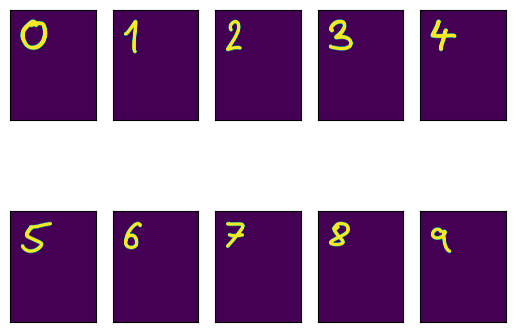

In [3]:
NCOLS = 5
fig, ax = plt.subplots(len(imgs)//NCOLS, NCOLS)
ax = ax.flatten()
for i, img in enumerate(imgs):
    ax[i].imshow(img)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.show()

### Find Bounding Boxes

The Bounding Box is obtained from the contours of the digit.

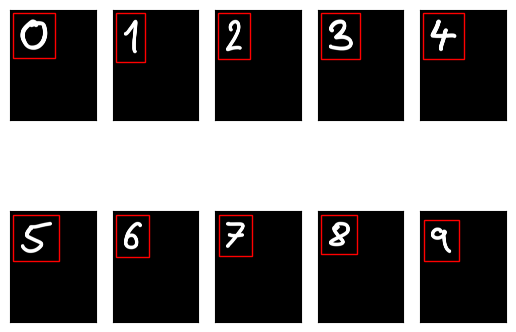

In [4]:
fig, ax = plt.subplots(len(imgs)//NCOLS, NCOLS)
ax = ax.flatten()

kernel = np.ones((3, 3), np.uint8)
digits = []
for i, img in enumerate(imgs):
	ax[i].imshow(img, cmap=plt.cm.gray)
	ax[i].set_xticks([])
	ax[i].set_yticks([])

	# dilate to add margins to the bounding box
	img_dilated = cv2.dilate(img, kernel, iterations=150)
 
	# retrieve all of the contours without establishing any hierarchical relationships
	contours, _ = cv2.findContours(img_dilated, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
	
	# extract a bounding rectangle from the last contour
	x, y, w, h = cv2.boundingRect(contours[-1])
	ax[i].add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none'))
	digits.append(img[y:y+h, x:x+w])

plt.show()

### Extract ROIs

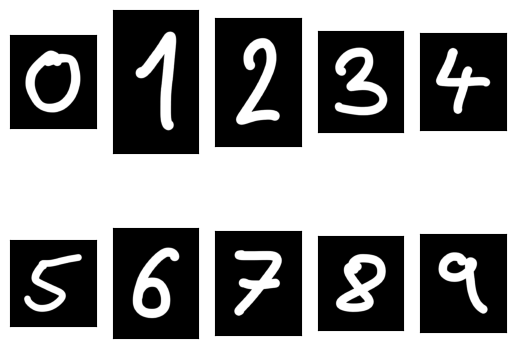

In [5]:
fig, ax = plt.subplots(len(imgs)//NCOLS, NCOLS)
ax = ax.flatten()

for i, digit in enumerate(digits):
    ax[i].imshow(digit, cmap=plt.cm.gray)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.show()

## Classification

For classification, we are going to use a CNN trained on the MNIST dataset. The CNN architecture and training code is taken from https://keras.io/examples/vision/mnist_convnet/.

### Load MNIST

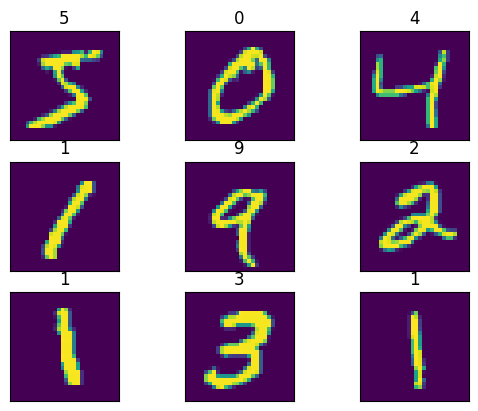

In [6]:
# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# visualize
fig, ax = plt.subplots(3, 3)
ax = ax.flatten()
for i in range(9):
    ax[i].imshow(x_train[i])
    ax[i].title.set_text(y_train[i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()

### MNIST Preprocessing

In [7]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


### Design of the network

In [8]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

### MNIST Training

In [9]:
batch_size = 128
epochs = 3

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/3
422/422 [==============================] - 28s 66ms/step - loss: 0.3684 - accuracy: 0.8869 - val_loss: 0.0870 - val_accuracy: 0.9760
Epoch 2/3
422/422 [==============================] - 25s 59ms/step - loss: 0.1171 - accuracy: 0.9639 - val_loss: 0.0609 - val_accuracy: 0.9837
Epoch 3/3
422/422 [==============================] - 25s 59ms/step - loss: 0.0891 - accuracy: 0.9729 - val_loss: 0.0491 - val_accuracy: 0.9885


### MNIST Test evaluation

In [10]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.04822319746017456
Test accuracy: 0.9842000007629395


### Test dataset evaluation

Before we feed our dataset into the network, we have to match its input dimensions to the MNIST dataset input dimensions, i.e., downsample our digits to 28x28 pixels.

1/1 [==============================] - 0s 23ms/step


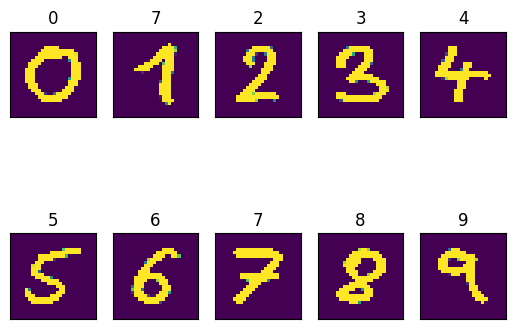

In [11]:
fig, ax = plt.subplots(len(imgs)//NCOLS, NCOLS)
ax = ax.flatten()

digits_rs = []
for i, digit in enumerate(digits):
    # resize to 28x28
    digit_rs = cv2.resize(digit, (28, 28), interpolation=cv2.INTER_CUBIC).astype(np.float32)/255
    
    # expand dimensions to create a batch
    digit_input = np.reshape(digit_rs, (1, 28, 28, 1))
    pred = model.predict(digit_input)
    
    ax[i].imshow(digit_rs)
    ax[i].title.set_text(np.argmax(pred))
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.show()

As we can see, the network classified 9 out of 10 handwritten digits correctly. 

Note that the only misclassification occured for the digit `1`, where the network predicted it as a `7`. This is mainly due to the fact that the 'ones' in the MNIST dataset are written as simple lines, i.e., without the preceding stroke.

## Shipping/Deployment

Our client would be given a single-page web application that could be run either remotely on a server or even locally, if privacy is a concern.

SPA details:
 - Backend
   - ASP.NET Web API
   - [ML.NET](https://dotnet.microsoft.com/en-us/apps/machinelearning-ai/ml-dotnet) for inference of a trained exported model in onxx format.
   - [OpenCvSharp](https://github.com/shimat/opencvsharp)
 - Frontend
   - Vue.js

## Conclusion

 - Whether the presented solution is robust enough depends on the additional information listed at the beginning of this document.
   - For our dataset, it gave satisfactory results.
 - For localization, we could also use deep learning approaches, such as **Mask R-CNN** or **YOLO**.
   - From the algorhitmic approaches, we could test various blob detection algorithms. [MSER](https://en.wikipedia.org/wiki/Maximally_stable_extremal_regions) is an example of a fairly lightweight one.
 - The classification accuracy could be improved by additional training of the network with different digit datasets (e.g., [Chars74K](http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/)).
 - If the digits would not be handwritten, an OCR engine, such as [Tesseract OCR](https://github.com/tesseract-ocr/tesseract), could be used.